<a href="https://colab.research.google.com/github/AkithaPasandul/Product-Recommendation-Engine/blob/main/Product_Recommendation_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import chain
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Loading

In [158]:
df = pd.read_csv("/content/1429_1.csv", engine='python')

In [159]:
df.head()

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [160]:
df.shape

(34660, 21)

column selection and rename

In [161]:
df = df[[
    "reviews.username",
    "asins",
    "reviews.rating",
    "reviews.text",
    "reviews.title",
    "reviews.date",
    "categories",
    "brand"
]]

df.rename(columns={
    "reviews.username": "user_id",
    "asins": "product_id",
    "reviews.rating": "rating",
    "reviews.text": "review_text",
    "reviews.title": "review_title",
    "reviews.date": "review_date"
}, inplace=True)

df.head()

,user_id,product_id,rating,review_text,review_title,review_date,categories,brand
0,Adapter,B01AHB9CN2,5.0,This product so far has not disappointed. My c...,Kindle,2017-01-13T00:00:00.000Z,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon
1,truman,B01AHB9CN2,5.0,great for beginner or experienced person. Boug...,very fast,2017-01-13T00:00:00.000Z,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon
2,DaveZ,B01AHB9CN2,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,2017-01-13T00:00:00.000Z,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon
3,Shacks,B01AHB9CN2,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,2017-01-13T00:00:00.000Z,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon
4,explore42,B01AHB9CN2,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,2017-01-12T00:00:00.000Z,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon


In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       34653 non-null  object 
 1   product_id    34658 non-null  object 
 2   rating        34627 non-null  float64
 3   review_text   34659 non-null  object 
 4   review_title  34654 non-null  object 
 5   review_date   34621 non-null  object 
 6   categories    34660 non-null  object 
 7   brand         34660 non-null  object 
dtypes: float64(1), object(7)
memory usage: 2.1+ MB


In [164]:
df.describe(include="all")

,user_id,product_id,rating,review_text,review_title,review_date,categories,brand
count,34653,34658,34627.000000,34659,34654,34621,34660,34660
unique,26788,41,NaN,34659,19766,1078,41,6
top,Mike,B018Y229OU,NaN,to spite the fact that i have nothing but good...,Great product,2017-01-16T00:00:00.000Z,"Fire Tablets,Tablets,Computers & Tablets,All T...",Amazon
freq,138,10966,NaN,1,645,710,10966,28701
mean,NaN,NaN,4.584573,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.735653,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN


# Data prepocessing

Missing values

In [165]:
(df.isnull().mean() * 100).sort_values(ascending=False)

,0
review_date,0.112522
rating,0.095211
user_id,0.020196
review_title,0.017311
product_id,0.005770
review_text,0.002885
categories,0.000000
brand,0.000000


In [166]:
df = df.dropna(subset=["user_id", "product_id", "rating"])
df["reviews.rating"] = pd.to_numeric(df["rating"], errors="coerce")

In [167]:
df.dropna(subset=["user_id", "product_id", "rating"], inplace=True)

Pick the first ASIN if multiple

In [168]:
df["product_id"] = df["product_id"].astype(str).str.split(",").str[0].str.strip()
df["user_id"] = df["user_id"].astype(str).str.strip()

Reviews date

In [169]:
if "review_date" in df.columns:
    df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")

Duplicates

In [170]:
duplicates = df.duplicated(subset=["user_id", "product_id", "rating", "review_text"]).sum()
print("Duplicate user-product reviews:", duplicates)

Duplicate user-product reviews: 0


In [171]:
df = df.drop_duplicates(subset=["user_id", "product_id", "reviews.rating", "review_text"])

Rating validation

In [172]:
df = df[df["rating"].between(1, 5)]

In [173]:
df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")
df["year"] = df["review_date"].dt.year

In [174]:
df.head()

,user_id,product_id,rating,review_text,review_title,review_date,categories,brand,reviews.rating,year
0,Adapter,B01AHB9CN2,5.0,This product so far has not disappointed. My c...,Kindle,2017-01-13 00:00:00+00:00,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,5.0,2017.0
1,truman,B01AHB9CN2,5.0,great for beginner or experienced person. Boug...,very fast,2017-01-13 00:00:00+00:00,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,5.0,2017.0
2,DaveZ,B01AHB9CN2,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,2017-01-13 00:00:00+00:00,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,5.0,2017.0
3,Shacks,B01AHB9CN2,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,2017-01-13 00:00:00+00:00,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,4.0,2017.0
4,explore42,B01AHB9CN2,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,2017-01-12 00:00:00+00:00,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,5.0,2017.0


# EDA

Dataset statistics

In [175]:
n_users = df["user_id"].nunique()
n_products = df["product_id"].nunique()
n_reviews = len(df)

In [176]:
print(f"Users: {n_users}")
print(f"Products: {n_products}")
print(f"Reviews: {n_reviews}")

Users: 26763
Products: 38
Reviews: 34618


In [177]:
sparsity = 1 - (n_reviews / (n_users * n_products))
print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.9660


## Rating Analysis

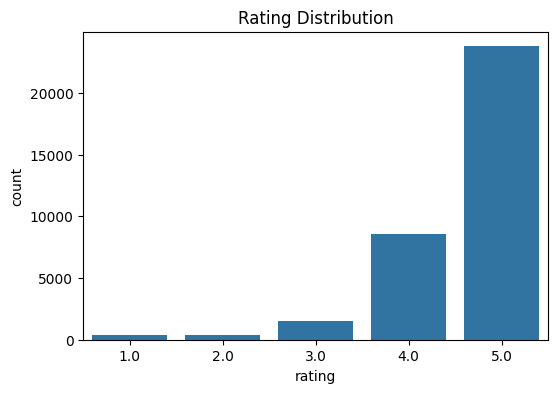

In [178]:
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=df)
plt.title("Rating Distribution")
plt.show()

In [179]:
df["rating"].value_counts(normalize=True).sort_index()

,proportion
rating,
1.0,0.011844
2.0,0.011584
3.0,0.043301
4.0,0.246692
5.0,0.686579


## User behavior analysis

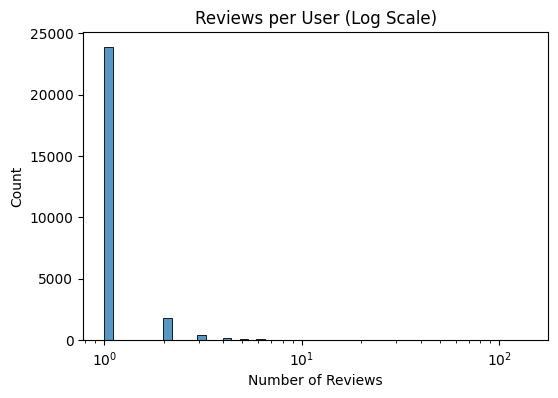

In [180]:
user_review_counts = df["user_id"].value_counts()

plt.figure(figsize=(6,4))
sns.histplot(user_review_counts, bins=50, log_scale=True)
plt.title("Reviews per User (Log Scale)")
plt.xlabel("Number of Reviews")
plt.show()

Most active users

In [181]:
user_review_counts.head(10)

,count
user_id,
Mike,138
Chris,93
John,85
Dave,70
Bill,58
Amazon Customer,57
Rick,52
Steve,49
Anonymous,46


## Product Analysis

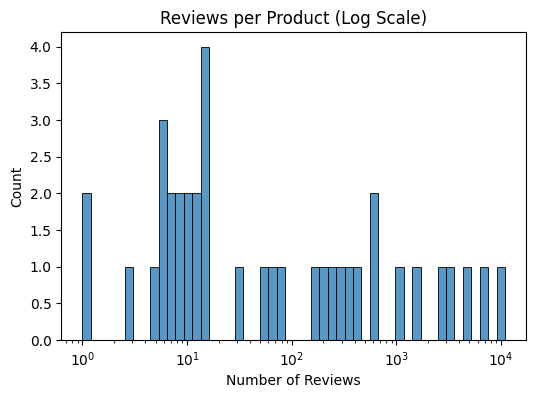

In [182]:
product_review_counts = df["product_id"].value_counts()

plt.figure(figsize=(6,4))
sns.histplot(product_review_counts, bins=50, log_scale=True)
plt.title("Reviews per Product (Log Scale)")
plt.xlabel("Number of Reviews")
plt.show()

In [183]:
product_review_counts.head(10)

,count
product_id,
B018Y229OU,10965
B00L9EPT8O,6618
B00U3FPN4U,5055
B00OQVZDJM,3175
B01AHB9CN2,2812
B018Y23MNM,1684
B018Y225IA,1038
B01BH83OOM,636
B00IOY8XWQ,580


## Category & brand analysis

Top category

In [184]:
df["categories"].value_counts().head(10)

,count
categories,
"Fire Tablets,Tablets,Computers & Tablets,All Tablets,Electronics, Tech Toys, Movies, Music,Electronics,iPad & Tablets,Android Tablets,Frys",10965
"Stereos,Remote Controls,Amazon Echo,Audio Docks & Mini Speakers,Amazon Echo Accessories,Kitchen & Dining Features,Speaker Systems,Electronics,TVs Entertainment,Clearance,Smart Hubs & Wireless Routers,Featured Brands,Wireless Speakers,Smart Home & Connected Living,Home Security,Kindle Store,Home Automation,Home, Garage & Office,Home,Voice-Enabled Smart Assistants,Virtual Assistant Speakers,Portable Audio & Headphones,Electronics Features,Amazon Device Accessories,iPod, Audio Player Accessories,Home & Furniture Clearance,Consumer Electronics,Smart Home,Surveillance,Home Improvement,Smart Home & Home Automation Devices,Smart Hubs,Home Safety & Security,Voice Assistants,Alarms & Sensors,Amazon Devices,Audio,Holiday Shop",6618
"Back To College,College Electronics,College Tvs & Home Theater,Electronics,Tvs & Home Theater,Streaming Devices,Featured Brands,Amazon Devices,Holiday Shop,Ways To Shop,TV & Home Theater,Streaming Media Players,All Streaming Media Players,TVs Entertainment,Video Games,Kindle Store,Electronics Features,Kids & Family,Fire TV",5055
"Walmart for Business,Office Electronics,Tablets,Office,Electronics,iPad & Tablets,Windows Tablets,All Windows Tablets,Computers & Tablets,E-Readers & Accessories,E-Readers,eBook Readers,Kindle E-readers,Computers/Tablets & Networking,Tablets & eBook Readers,Electronics Features,Books & Magazines,Book Accessories,eReaders,TVs & Electronics,Computers & Laptops,Tablets & eReaders",3175
"Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets",2812
"Tablets,Fire Tablets,Computers & Tablets,All Tablets",1698
"Computers/Tablets & Networking,Tablets & eBook Readers,Computers & Tablets,Tablets,All Tablets",1038
"Featured Brands,Electronics,Amazon Devices,Home,Home Improvement,Home Safety & Security,Home Security,Alarms & Sensors,Smart Home & Home Automation Devices,Mobile,Mobile Speakers,Mobile Bluetooth Speakers,Smart Hubs & Wireless Routers,Smart Hubs,Home, Garage & Office,Smart Home,Voice Assistants,Smart Home & Connected Living,Amazon Tap,Portable Audio,MP3 Accessories,Speakers,Amazon Echo,Electronics Features,TVs & Electronics,Portable Audio & Electronics,MP3 Player Accessories,Home Theater & Audio,Kindle Store,Frys,Electronic Components,Home Automation,Electronics, Tech Toys, Movies, Music,Audio,Bluetooth Speakers",636
"Walmart for Business,Office Electronics,Tablets,Electronics,iPad & Tablets,All Tablets,Computers & Tablets,E-Readers & Accessories,Kindle E-readers,Electronics Features,eBook Readers,See more Amazon Kindle Voyage (Wi-Fi),See more Amazon Kindle Voyage 4GB, Wi-Fi 3G (Unlocked...",580


Top brand

In [185]:
df["brand"].value_counts().head(10)

,count
brand,
Amazon,28661
Amazon Fire Tv,5055
Amazon Echo,636
Amazon Fire,256
Amazon Digital Services Inc.,10


## Review text analysis

Review length

In [186]:
df['review_length'] = df['review_text'].astype(str).str.split().str.len()

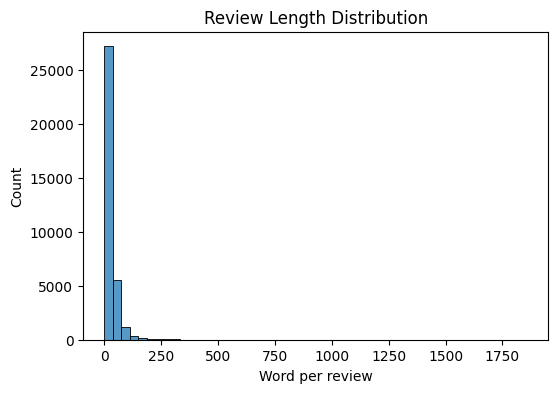

In [187]:
plt.figure(figsize=(6,4))
sns.histplot(df['review_length'], bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Word per review")
plt.show()

Common words

In [188]:
sample_reviews = df["review_text"].dropna().sample(3000, random_state=42)
words = list(chain.from_iterable(sample_reviews.str.lower().str.split()))

In [189]:
Counter(words).most_common(20)

[('the', 3794),
 ('to', 2901),
 ('and', 2831),
 ('i', 2734),
 ('for', 2181),
 ('it', 2103),
 ('a', 2077),
 ('is', 1758),
 ('my', 1512),
 ('this', 1464),
 ('of', 939),
 ('great', 854),
 ('with', 783),
 ('on', 752),
 ('you', 704),
 ('have', 652),
 ('that', 600),
 ('was', 598),
 ('in', 566),
 ('but', 558)]

Interaction matrix analysis

In [190]:
user_item_matrix = df.pivot_table(
    index="user_id",
    columns="product_id",
    values="rating"
)

print("User-Item Matrix Shape:", user_item_matrix.shape)

User-Item Matrix Shape: (26763, 38)


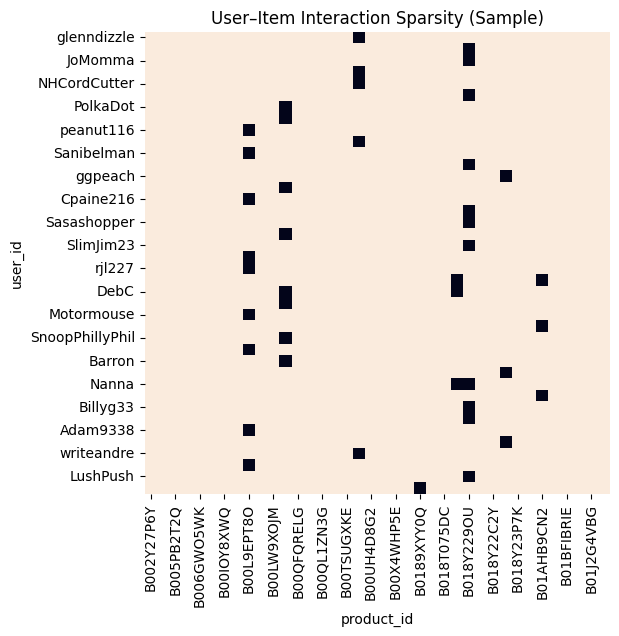

In [191]:
sample_matrix = user_item_matrix.sample(40).iloc[:, :40]

plt.figure(figsize=(6,6))
sns.heatmap(sample_matrix.isnull(), cbar=False)
plt.title("User–Item Interaction Sparsity (Sample)")
plt.show()

# Filtering for modeling

In [192]:
MIN_USER_REVIEWS = 3
MIN_PRODUCT_REVIEWS = 3

In [193]:
user_counts = df["user_id"].value_counts()
prod_counts = df["product_id"].value_counts()

In [194]:
df = df[df["user_id"].isin(user_counts[user_counts >= MIN_USER_REVIEWS].index)]
df = df[df["product_id"].isin(prod_counts[prod_counts >= MIN_PRODUCT_REVIEWS].index)]

Keep only required columns

In [195]:
 interactions = df[["user_id", "product_id", "reviews.rating"]].copy()

In [196]:
print("Clean interactions:", interactions.shape)
print(interactions.head())

Clean interactions: (7062, 3)
   user_id  product_id  reviews.rating
16   Linda  B01AHB9CN2             4.0
26    Dave  B01AHB9CN2             4.0
27   James  B01AHB9CN2             5.0
34    rick  B01AHB9CN2             5.0
36    Gift  B01AHB9CN2             4.0


# Models

## Model 1: Popularity based recommender

In [197]:
class PopularityRecommender:
    def __init__(self, min_reviews=10):
        self.min_reviews = min_reviews
        self.pop_table = None

    def fit(self, df_interactions: pd.DataFrame):
        stats = df_interactions.groupby("product_id")["reviews.rating"].agg(["mean", "count"]).reset_index()
        # Filter products with enough ratings
        stats = stats[stats["count"] >= self.min_reviews].copy()

        # Weighted rating (IMDB-style)
        C = df_interactions["reviews.rating"].mean()
        m = self.min_reviews
        stats["weighted_score"] = (stats["count"] / (stats["count"] + m)) * stats["mean"] + (m / (stats["count"] + m)) * C

        self.pop_table = stats.sort_values("weighted_score", ascending=False)
        return self

    def recommend(self, n=10):
        return self.pop_table.head(n)[["product_id", "weighted_score", "mean", "count"]]


In [198]:
pop_model = PopularityRecommender(min_reviews=10).fit(interactions)
pop_model.recommend(10)

,product_id,weighted_score,mean,count
7,B00OQVZDJM,4.758689,4.761103,653
4,B00IOYAM4I,4.750552,4.900000,10
13,B00U3FPN4U,4.699081,4.700104,957
5,B00L9EPT8O,4.674622,4.675141,1416
3,B00IOY8XWQ,4.671309,4.676471,136
24,B018Y23MNM,4.624088,4.624679,389
27,B01AHB9CYG,4.619311,4.625000,32
26,B01AHB9CN2,4.616843,4.617143,525
15,B00VINDBJK,4.607537,4.611111,18
29,B01BH83OOM,4.557032,4.554054,148


## Build user-item matrix

In [199]:
user_to_idx = {u:i for i, u in enumerate(interactions["user_id"].unique())}
item_to_idx = {p:i for i, p in enumerate(interactions["product_id"].unique())}
idx_to_user = {i:u for u,i in user_to_idx.items()}
idx_to_item = {i:p for p,i in item_to_idx.items()}

In [200]:
interactions["u_idx"] = interactions["user_id"].map(user_to_idx)
interactions["i_idx"] = interactions["product_id"].map(item_to_idx)

In [201]:
rows = interactions["u_idx"].values
cols = interactions["i_idx"].values
vals = interactions["reviews.rating"].values.astype(np.float32)

In [202]:
R = csr_matrix((vals, (rows, cols)), shape=(len(user_to_idx), len(item_to_idx)))
R.shape

(1031, 32)

## Model 2: Item based collaborative filtering

In [203]:
class ItemKNNRecommender:
    def __init__(self, top_k_sim=50):
        self.top_k_sim = top_k_sim
        self.item_sim = None
        self.R = None

    def fit(self, R: csr_matrix):
        self.R = R
        # item vectors = columns => use R.T
        sim = cosine_similarity(R.T, dense_output=False)
        self.item_sim = sim
        return self

    def recommend(self, user_index: int, n=10, min_rating_like=4.0):
        user_ratings = self.R[user_index].toarray().ravel()
        liked_items = np.where(user_ratings >= min_rating_like)[0]

        if len(liked_items) == 0:
            # fallback: recommend most-rated items
            item_pop = np.array(self.R.getnnz(axis=0)).ravel()
            rec_items = item_pop.argsort()[::-1][:n]
            return rec_items

        # Score items by similarity to liked items (weighted)
        scores = np.zeros(self.R.shape[1], dtype=np.float32)
        for item in liked_items:
            sim_vec = self.item_sim[item].toarray().ravel()
            scores += sim_vec * user_ratings[item]

        # remove already rated items
        scores[np.where(user_ratings > 0)[0]] = -np.inf

        rec_items = np.argsort(scores)[::-1][:n]
        return rec_items

# Fit
item_knn = ItemKNNRecommender(top_k_sim=50).fit(R)

In [204]:
# Example
some_user = interactions["user_id"].iloc[0]
u = user_to_idx[some_user]
rec_item_indices = item_knn.recommend(u, n=10)
[ idx_to_item[i] for i in rec_item_indices ]

['B00U3FPN4U',
 'B018Y23MNM',
 'B00IOY8XWQ',
 'B01BH83OOM',
 'B018SZT3BK',
 'B00VINDBJK',
 'B01AHB9CYG',
 'B00QFQRELG',
 'B00IOYAM4I',
 'B002Y27P6Y']

## Model 3: User based collaborative filtering

In [205]:
class UserKNNRecommender:
    def __init__(self):
        self.user_sim = None
        self.R = None

    def fit(self, R: csr_matrix):
        self.R = R
        self.user_sim = cosine_similarity(R, dense_output=False)
        return self

    def recommend(self, user_index: int, n=10):
        user_ratings = self.R[user_index].toarray().ravel()
        sims = self.user_sim[user_index].toarray().ravel()

        # Weighted sum of other users' ratings
        scores = sims @ self.R.toarray()  # simple (works for this dataset size)

        # remove already rated
        scores[np.where(user_ratings > 0)[0]] = -np.inf

        rec_items = np.argsort(scores)[::-1][:n]
        return rec_items

user_knn = UserKNNRecommender().fit(R)

In [206]:
u = user_to_idx[interactions["user_id"].iloc[0]]
rec_item_indices = user_knn.recommend(u, n=10)
[ idx_to_item[i] for i in rec_item_indices ]

['B00U3FPN4U',
 'B018Y23MNM',
 'B01BH83OOM',
 'B00IOY8XWQ',
 'B018SZT3BK',
 'B01AHB9CYG',
 'B01J2G4VBG',
 'B00VINDBJK',
 'B00QFQRELG',
 'B00IOYAM4I']

## Model 4: Matrix factorization

In [207]:
class SVDRecommender:
    def __init__(self, n_components=50, random_state=42):
        self.n_components = n_components
        self.random_state = random_state
        self.svd = None
        self.user_factors = None
        self.item_factors = None
        self.R = None

    def fit(self, R: csr_matrix):
        self.R = R
        max_possible_components = R.shape[1] - 1
        if max_possible_components < 1:
            actual_n_components = 1
        else:
            actual_n_components = min(self.n_components, max_possible_components)

        self.svd = TruncatedSVD(n_components=actual_n_components, random_state=self.random_state)
        self.user_factors = self.svd.fit_transform(R)
        self.item_factors = self.svd.components_
        return self

    def recommend(self, user_index: int, n=10):
        user_ratings = self.R[user_index].toarray().ravel()

        # predicted scores = user_factors[user] dot item_factors
        scores = self.user_factors[user_index] @ self.item_factors

        # remove already rated
        scores[np.where(user_ratings > 0)[0]] = -np.inf

        rec_items = np.argsort(scores)[::-1][:n]
        return rec_items

svd_model = SVDRecommender(n_components=50).fit(R)

In [208]:
u = user_to_idx[interactions["user_id"].iloc[0]]
rec_item_indices = svd_model.recommend(u, n=10)
[ idx_to_item[i] for i in rec_item_indices ]

['B018SZT3BK',
 'B018Y23MNM',
 'B00VINDBJK',
 'B00U3FPN4U',
 'B00IOY8XWQ',
 'B01BFIBRIE',
 'B01AHB9CYG',
 'B01BH83OOM',
 'B002Y27P6Y',
 'B01J4ORNHU']

## Model 5: Content based(TF-IDF on reviews)

In [209]:
class ContentBasedRecommender:
    def __init__(self, max_features=30000):
        self.max_features = max_features
        self.vectorizer = TfidfVectorizer(stop_words="english", max_features=max_features)
        self.tfidf = None
        self.product_ids = None
        self.product_to_row = None
        self.sim = None

    def fit(self, df_full: pd.DataFrame):
        # Build product documents
        temp = df_full.copy()
        temp["review_text"] = temp["review_text"].fillna("")
        temp["review_title"] = temp["review_title"].fillna("")
        temp["doc"] = (temp["review_title"] + " " + temp["review_text"]).str.lower()

        prod_docs = temp.groupby("product_id")["doc"].apply(lambda x: " ".join(x)).reset_index()
        self.product_ids = prod_docs["product_id"].tolist()
        self.product_to_row = {p:i for i,p in enumerate(self.product_ids)}

        self.tfidf = self.vectorizer.fit_transform(prod_docs["doc"])
        self.sim = cosine_similarity(self.tfidf, dense_output=False)
        return self

    def recommend_similar_products(self, product_id: str, n=10):
        if product_id not in self.product_to_row:
            return []
        row = self.product_to_row[product_id]
        sims = self.sim[row].toarray().ravel()
        top = np.argsort(sims)[::-1][1:n+1]
        return [self.product_ids[i] for i in top]

content_model = ContentBasedRecommender().fit(df)

In [210]:
example_product = df["product_id"].iloc[0]
content_model.recommend_similar_products(example_product, n=10)

['B018Y229OU',
 'B018Y225IA',
 'B00TSUGXKE',
 'B018SZT3BK',
 'B018Y23MNM',
 'B0189XYY0Q',
 'B00ZV9PXP2',
 'B00OQVZDJM',
 'B01AHB9CYG',
 'B01AHB9C1E']

## Simple Evaluation

In [212]:
def train_test_split_per_user(df_inter, test_size=0.2, seed=42):
    rng = np.random.RandomState(seed)
    train_rows = []
    test_rows = []

    for u, g in df_inter.groupby("user_id"):
        if len(g) < 5:
            train_rows.append(g)
            continue
        idx = g.index.values
        rng.shuffle(idx)
        cut = int(len(idx) * (1 - test_size))
        train_rows.append(df_inter.loc[idx[:cut]])
        test_rows.append(df_inter.loc[idx[cut:]])

    train_df = pd.concat(train_rows).reset_index(drop=True)
    test_df = pd.concat(test_rows).reset_index(drop=True) if test_rows else pd.DataFrame(columns=df_inter.columns)
    return train_df, test_df

In [230]:
def precision_recall_at_k(model, train_R, test_df, k=10, like_threshold=4.0):
    test_like = {}
    for r in test_df.itertuples(index=False):
        if r.rating >= like_threshold:
            test_like.setdefault(r.user_id, set()).add(r.product_id)

    precisions, recalls = [], []
    for user_id, true_items in test_like.items():
        if user_id not in user_to_idx:
            continue
        u = user_to_idx[user_id]
        rec_idx = model.recommend(u, n=k)
        rec_items = set(idx_to_item[i] for i in rec_idx)

        hit = len(rec_items & true_items)
        precisions.append(hit / k)
        recalls.append(hit / len(true_items))

    return float(np.mean(precisions)) if precisions else 0.0, float(np.mean(recalls)) if recalls else 0.0

Make df_inter with correct column names for evaluation

In [231]:
train_df, test_df = train_test_split_per_user(df_inter, test_size=0.2)

 Rebuild matrix for TRAIN only

In [232]:
user_to_idx = {u:i for i, u in enumerate(train_df["user_id"].unique())}
item_to_idx = {p:i for i, p in enumerate(train_df["product_id"].unique())}
idx_to_item = {i:p for p,i in item_to_idx.items()}

In [233]:
train_df["u_idx"] = train_df["user_id"].map(user_to_idx)
train_df["i_idx"] = train_df["product_id"].map(item_to_idx)

In [234]:
rows = train_df["u_idx"].values
cols = train_df["i_idx"].values
vals = train_df["rating"].values.astype(np.float32)

In [235]:
train_R = csr_matrix((vals, (rows, cols)), shape=(len(user_to_idx), len(item_to_idx)))

In [236]:
item_knn = ItemKNNRecommender().fit(train_R)
p, r = precision_recall_at_k(item_knn, train_R, test_df, k=10)
print("ItemKNN Precision@10:", p, "Recall@10:", r)

ItemKNN Precision@10: 0.0632286995515695 Recall@10: 0.36690244857285215
